# Truncated stick breaking in Greta

Here, we briefly discuss variational inference for truncated stick breaking (TSB). We use TSB as a finite-dimensional alternative to an infinite dimensional prior over number of mixture components. We do the analysis in R (cause the author is more comfortable with it). 

In this notebook we use an *error probability* likelihood.

Since we are mainly interested in speed of the inference, this notebook will sooner or later be translated to Edward2, because it has better support for VI than Stan or Greta.

Some required libraries:

In [1]:
suppressMessages(library("greta"))
suppressMessages(library("tensorflow"))
suppressMessages(library("rethinking"))

In [2]:
suppressMessages(library("tidyverse"))
suppressMessages(library("coda"))
suppressMessages(library("bayesplot"))
suppressMessages(library("MASS"))

In [3]:
set.seed(23)

In [4]:
options(repr.plot.width=8, repr.plot.height=3)

In [5]:
N <- 1000
K <- 3
P <- 2

In [10]:
mus <- c(2, 7, 15)

In [11]:
data <- matrix(0, N * K, 2)
for (k in seq(K)) {    
    idx <- seq(N) + ((k - 1) * N)
    data[idx,] <- rpois(N, mus[k])
}

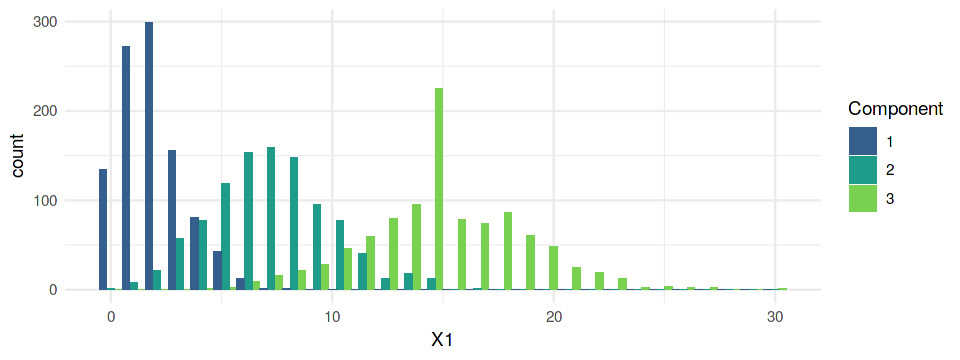

In [12]:
data.frame(data, idx=as.factor(rep(seq(K), each=N))) %>%
    ggplot(aes(X1, fill=idx)) +
    geom_histogram(bins=30, position = "dodge") +
    scale_fill_viridis_d("Component", alpha = 1, begin=.3, end=.8) + 
    theme_minimal()

We truncate the DP at $K=5$ and define the model.

In [53]:
K <- 5

In [66]:
prior_mu_ordered <- cumsum(greta::variable(lower = 0, dim = K))

In [68]:
stick_breaking <- function(theta) {
   M <- length(theta) + 1
    theta <- c(theta, 1)
    p <- rep(theta[1], length(theta))
    for (m in 1:(M - 1)) {
        p[m + 1] <- theta[m + 1] * (1 - theta[m]) * p[m]/theta[m]
    }
    p <- cumsum(p)
    p / sum(p)
}

prior_shape <- greta::gamma(1, 1)
# note the K - 1 which is required for LaplacesDemon::Stick (yes it's dumb)
prior_stick <- greta::beta(1, prior_shape, dim = K - 1)
prior_weights <- stick_breaking(prior_stick)

In [69]:
greta::distribution(data) <- greta::mixture(
    greta::poisson(prior_mu[1]),
    greta::poisson(prior_mu[2]),
    greta::poisson(prior_mu[3]),
    greta::poisson(prior_mu[4]),
    greta::poisson(prior_mu[5]),
    weights = prior_weights
)

In [70]:
mod <- greta::model(prior_shape, prior_stick, prior_weights, prior_mu)

In [71]:
samples <- greta::mcmc(
    mod,
    chains = 1,
    n_cores = 1,
    initial_values = initials(prior_mu = seq(K))
)

    warmup ====================================== 1000/1000 | eta:  0s | <1% bad
  sampling ====================================== 1000/1000 | eta:  0s          


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


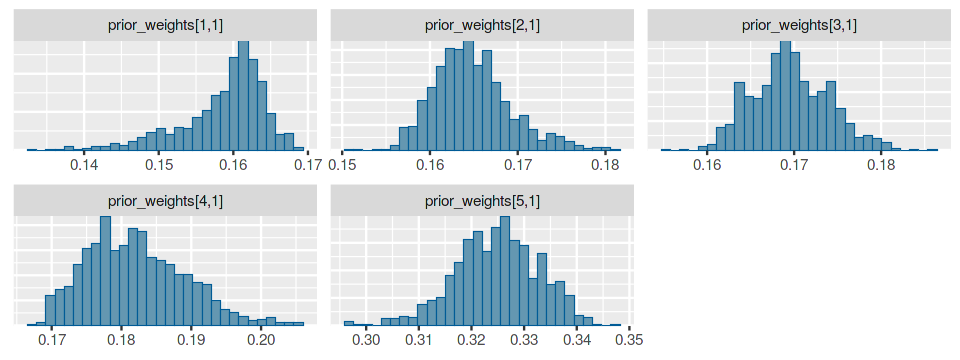

In [72]:
bayesplot::mcmc_hist(samples, regex_pars = "weights")

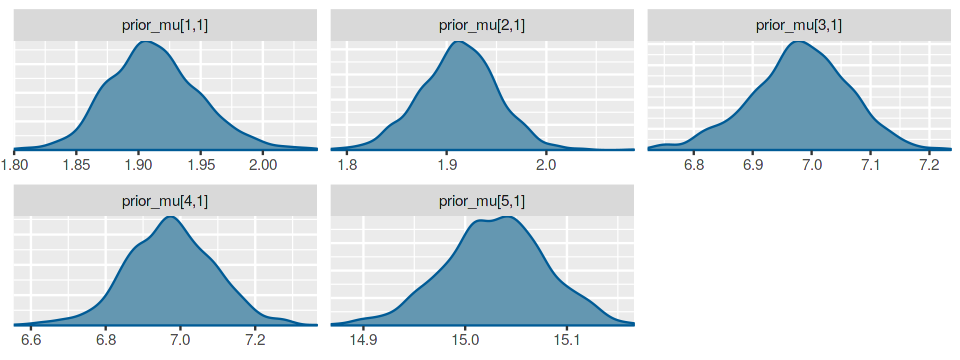

In [73]:
bayesplot::mcmc_dens(samples, regex_pars = "mu")

## Model calibration with HMC

For convenience, ease of implementation, and to see if our model is well-specified we use Greta and HMC first. This requires to load some internals to be able to define a custom likelihood.

In [5]:
distribution_node <- .internals$nodes$node_classes$distribution_node
as.greta_array    <- .internals$greta_arrays$as.greta_array
check_dims <- .internals$utils$checks$check_dims
distrib    <- .internals$nodes$constructors$distrib
fl     <- .internals$utils$misc$fl
tf_sum <- greta:::tf_sum

We define the likelihood below. It is a class called *error_probability_distribution* and will be used to interact with tensorflow (TF). TF requires for every variable that we use, to define the log density (in `tf_distrib::log_prob`). The rest is wrapping R code into code that is readable for TF. Thus onlt the `log_prob` function is important (unless you want to sample from that distribution which would be useful, since then we could define it as prior and do PPCs).

In [6]:
error_probability_distribution <- R6Class(
  "error_probability_distribution",
  inherit = distribution_node,
  public = list(
    initialize = function(theta, alpha, beta, dim) {
      theta <- as.greta_array(theta)
      alpha <- as.greta_array(alpha)
      beta <- as.greta_array(beta)
        
      dim <- check_dims(theta, alpha, beta, target_dim = dim)
      super$initialize("error_probability", dim, discrete = TRUE)
      self$add_parameter(theta, "theta")
      self$add_parameter(alpha, "alpha")
      self$add_parameter(beta, "beta")
    },
    
    tf_distrib = function(parameters, dag) {
      theta <- parameters$theta
      alpha <- parameters$alpha
      beta <- parameters$beta
        
      log_prob <- function(x) {
        tf_sum(
            log(
                theta * ((fl(1) - beta)**x * beta**(fl(1) - x)) +
                (fl(1) - theta) * ((fl(1) - alpha)**(fl(1) - x) * alpha**x)
            )            
        )
      }
      
      list(log_prob = log_prob, cdf = NULL, log_cdf = NULL)
    },
    
    tf_cdf_function = NULL,
    tf_log_cdf_function = NULL
  )
)

We wrap the class in a function to easily create an instance of.

In [7]:
error_probability <- function(theta, alpha, beta, dim = NULL) {
  distrib("error_probability", theta, alpha, beta, dim)
}

Next we create data from the generating process of the model. First define some true parameters (for ease of computation constants and not distributions). Our "true" data will be a mixture of three components.

In [8]:
K <- 3

In [9]:
params <- matrix(
    c(seq(0.1, 0.9, length.out = K), 
      seq(.05, 0.3, length.out = K),
      seq(0.3, .05, length.out = K)),
    3, byrow = TRUE, dimnames=list(c("theta", "alpha", "beta"), NULL)
)
params

theta,0.10,0.500,0.90
alpha,0.05,0.175,0.30
beta,0.30,0.175,0.05


Every column represents a component of the mixture. The first row describes the "thetas" for every component, i.e. if a mutation is a FP or FN. Analogously the second and third row are the FN and FP rates for every component.

In R we can easily subset with strings and integers (R is 1-indexed).

In [10]:
params["beta", 1]

beta 
 0.3

Then we define some data. In total 1000 data points per component. We use only five-dimensional random variables, in order to make the plots afterwards more concise and not bloated.

In [11]:
N <- 1000
P <- 5

In [12]:
data <- matrix(0, N * K, P)
for (k in seq(K)) {
    for (n in seq(N)) {        
        idx <- n + ((k - 1) * N)        
        if (runif(1, 0, 1) > params["theta", k]) {
            data[idx,] <- rbinom(P, 1, 1 - params["beta", k])
        } else {                
            data[idx,] <- rbinom(P, 1, params["alpha", k])
        }
    }            
}

For the TSB, we use maximally $K=5$ components. Truncating the DP at some sufficiently high $K$ is enough to achieve a negligibly small error in comparison to a "true" infinite dimensional prior.

See for instance https://projecteuclid.org/euclid.bj/1551862850 for a theoretical and practical justification for the tunrcation.

In [14]:
K <- 5

In Greta we define priors like this. We use $K$ dimensional priors for every parameter, i.e. $\theta$, $\alpha$ and $\beta$

In [15]:
prior_theta <- greta::beta(1, 1, dim = K)
prior_beta <- greta::beta(1, 1, dim = K)
prior_alpha <- greta::beta(1, 1, dim = K)

Then we define the stick breaking construction. We set a prior on the second shape paramter of the Beta, even though this will probably not work.

In [16]:
stick_breaking <- function(prior_stick) {
    LaplacesDemon::Stick(prior_stick)
}

prior_shape <- greta::gamma(1, 1)
# note the K - 1 which is required for LaplacesDemon::Stick (yes it's dumb)
prior_stick <- greta::beta(1, prior_shape, dim = K - 1)
prior_weights <- stick_breaking(prior_stick)

This part is somewhat ugly in R. We define a common mixture with Greta and then need to manually add the components.
(this can be done way nice in Python with `*args`).

In [17]:
likelihood <- function(data, pt, pa, pb, pw) {
    distribution(data) <- greta::mixture(
        error_probability(pt[1], pa[1], pb[1]),
        error_probability(pt[2], pa[2], pb[2]),
        error_probability(pt[3], pa[3], pb[3]),
        error_probability(pt[4], pa[4], pb[4]),
        error_probability(pt[5], pa[5], pb[5]),
        weights = pw)
}

In [18]:
likelihood(data, prior_theta, prior_alpha, prior_beta, prior_weights)

Then we create the model.

In [19]:
mod <- greta::model(
    prior_theta, prior_beta, prior_alpha,
    prior_shape, prior_stick, prior_weights)

.. and sample from the posterior. To be able to do some diagnostics, we need at least two chains.

In [20]:
system.time(
    samples <- greta::mcmc(mod, chains = 2, n_cores = 2, n_samples = 2000)
)


running 2 chains simultaneously on up to 2 cores

    warmup ====================================== 1000/1000 | eta:  0s          
  sampling ====================================== 2000/2000 | eta:  0s          


    user   system  elapsed 
4465.999   47.508 1455.101 

In [22]:
coda::gelman.diag(samples)

ERROR: Error in chol.default(W): the leading minor of order 24 is not positive definite


Whoops! For some reason (presumably poor mixing) there are numerical issues computing diagnostics for the posteriors. Let's still have a look at the posterior mixing weights. With these we can infer how many components we need.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


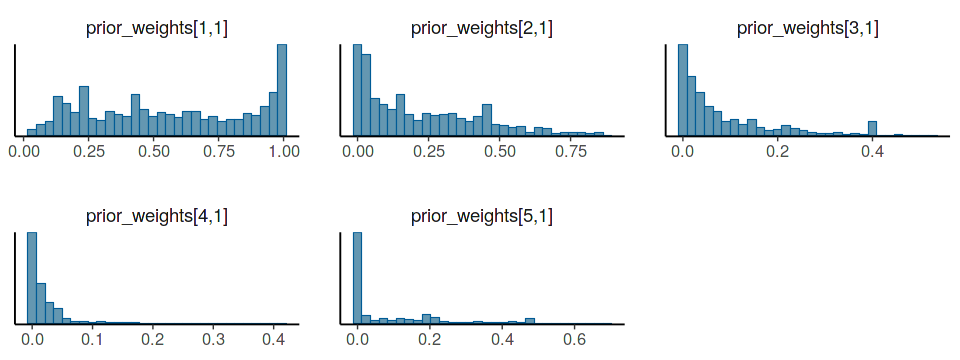

In [23]:
bayesplot::mcmc_hist(samples[[1]], regex_pars =  "weights")

Looks like three components is fine, just as we defined the data. Now let's look at all the parameters. We can do that concisely with an interval plot.

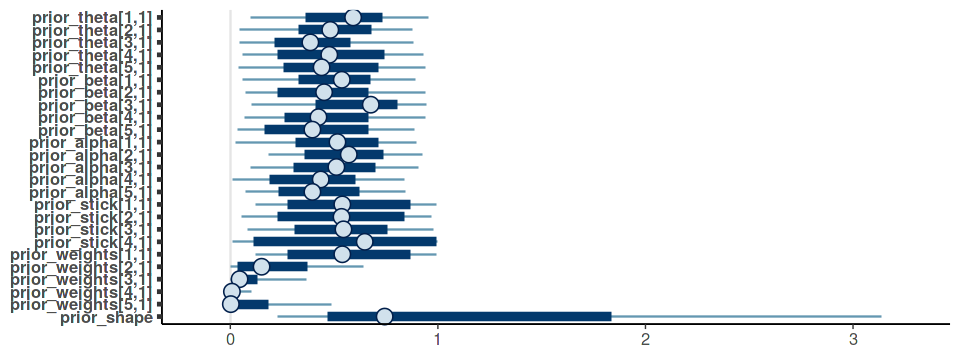

In [24]:
bayesplot::mcmc_intervals(samples[[1]])

It looks as the parameters fir a single component are not identifiable. At least all the medians are around $.5$. Since we used sufficiently large data and enough samples, it's safe to assume that the model is ill-defined.